------Vehicle Detection-------
The goals / steps of this project are the following:
- Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier   Linear SVM classifier
- Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG   feature vector.
- Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
- Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
- Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a   heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
- Estimate a bounding box for vehicles detected.

In [21]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
from library import *
from libUdacity import *


In [22]:
# Data collection
cars = []  #to store car images.
for fi in glob.glob('.\\vehicles\\vehicles\\G*'):
    cars.extend(glob.glob(fi +'\\*.png'))
for fi in glob.glob('.\\vehicles\\vehicles\\K*'):
    cars.extend(glob.glob(fi +'\\*.png'))
    
print("Samples in Car data set: ", len(cars))

notcars = [] #to store non car images
for nfi in glob.glob('.\\non-vehicles\\non-vehicles\\Extras\\*.png'):
    notcars.append(nfi)
for nfi in glob.glob('.\\non-vehicles\\non-vehicles\\GTI\\*.png'):
    notcars.append(nfi)
    
print("Samples in not-Cars data set: ", len(notcars))

Samples in Car data set:  8792
Samples in not-Cars data set:  8968


Reduction of samples in cars and not-cars data set to:  1000
Feature vector length: 3168
Spatial binning: 32  and Histogram bins : 32


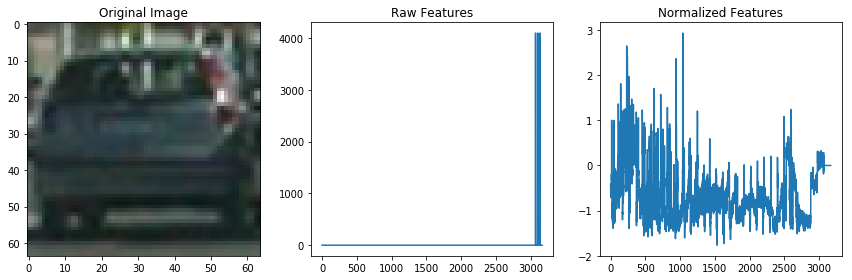

In [23]:
#Trial
nreduction = 1000
carsReduced = cars[0:nreduction] 
notcarsReduced = notcars[0:nreduction]
spatial=32
histbin=32
car_features = extract_features(carsReduced, color_space='RGB', spatial_size=(spatial, spatial),
                               hist_bins=histbin, hog_feat=False)
notcar_features = extract_features(notcarsReduced, color_space='RGB', spatial_size=(spatial, spatial),
                               hist_bins=histbin, hog_feat=False)

print("Reduction of samples in cars and not-cars data set to: ", nreduction)
print('Feature vector length:', len(notcar_features[0]))
print('Spatial binning:',spatial,' and Histogram bins :', histbin)

%matplotlib inline
if len(car_features) > 0:
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(carsReduced))
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(carsReduced[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Function only returns empty feature vectors!!')

In [24]:
#Train a Classifier
# Define a labels vector based on features lists
y = np.hstack((np.ones(len(car_features)),np.zeros(len(notcar_features))))

# Stack the features vectors together followed by normalization:
X = np.vstack((car_features, notcar_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

In [25]:
#Split feature vectors and labels into training and test set using train_test_split from sklearn. 
# version sklearn <0.18:
#from sklearn.cross_validation import train_test_split
# scikit-learn >= 0.18:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import time

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

#Classifier training
svc = LinearSVC() # Use a linear SVC 
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC')

#Accuracy and predictions
print('Test Accuracy of SVC classifier = ', svc.score(X_test, y_test))
t=time.time()
n_predict = 10
print('SVC prediction : ', svc.predict(X_test[0:n_predict]))
print('For ',n_predict, ' labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

2.47 Seconds to train SVC
Test Accuracy of SVC classifier =  0.9575
SVC prediction :  [ 0.  1.  0.  0.  0.  1.  1.  0.  1.  0.]
For  10  labels:  [ 0.  1.  0.  0.  0.  1.  1.  0.  1.  0.]
0.002 Seconds to predict 10 labels with SVC


In [26]:
#Histogram of Oriented Gradients
colorspace = 'HLS' # we can have also RGB, HSV, LUV, HLS, YUV or YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL"


t=time.time()

car_features = extract_features(carsReduced, color_space='HLS',orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block,hog_channel=hog_channel, spatial_feat=False, 
                        hist_feat=False, hog_feat=True)
notcar_features = extract_features(notcarsReduced, color_space='HLS',orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block,hog_channel=hog_channel, spatial_feat=False, 
                        hist_feat=False, hog_feat=True)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

# Labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Train test data split
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print(orient,' orientations, ',pix_per_cell,' pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0])) 
svc = LinearSVC() # Use a linear SVC

t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC classifier')
# Score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Prediction time for a single sample
t=time.time()
n_predict = 7
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

C:\Users\Karthik\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


11.07 Seconds to extract HOG features...
9  orientations,  8  pixels per cell and 2 cells per block
Feature vector length: 5292
0.32 Seconds to train SVC classifier
Test Accuracy of SVC =  0.9975
My SVC predicts:  [ 0.  1.  0.  1.  1.  1.  1.]
For these 7 labels:  [ 0.  1.  0.  1.  1.  1.  1.]
0.002 Seconds to predict 7 labels with SVC


## [Rubric](https://review.udacity.com/#!/rubrics/513/view) Points
---
Here I will consider the rubric points individually and describe how I addressed each point in my implementation.  

## Writeup / README
---

- Provide a Writeup / README that includes all the rubric points and how you addressed each one.  You can submit your writeup as markdown or pdf.  [Here](https://github.com/udacity/CarND-Vehicle-Detection/blob/master/writeup_template.md) is a template writeup for this project you can use as a guide and a starting point.  

You're reading it!


######Feature Detection#######
Explain how (and identify where in your code) you extracted HOG features from the training images. Explain how you settled on your final choice of HOG parameters.
- Explored different HOG parameters (orientations, pixels_per_cell, and cells_per_block).
The final set of parameters is as defined below.

In [27]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off

nSamples = 8792 #Samples in car dataset
carsReduced = cars[0:nSamples] 
notcarsReduced = notcarsReduced[0:nSamples] 
print("Samples in cars and not-cars data set to: ", nSamples)

car_features = extract_features(carsReduced, color_space=color_space,spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell,cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat,hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcarsReduced, color_space=color_space,spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat,hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


Samples in cars and not-cars data set to:  8792


C:\Users\Karthik\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [31]:
from sklearn.utils import shuffle
def split_n_shuffle(features, labels, split):
    feat_train=features[0:0]; label_train=np.array([])
    feat_test=features[0:0]; label_test=np.array([])
    for cls in range(2):
        #print(features)
        feat_cls=features[labels==cls]
        #print(feat_cls)
        n_cls = len(feat_cls)
        feat_cls_train=feat_cls[0:int(split*n_cls)]; feat_cls_test=feat_cls[int(split*n_cls):n_cls]
        #print(feat_cls_train)
        #print(feat_cls_test)
        label_cls_train=np.ones(len(feat_cls_train))*cls
        label_cls_test=np.ones(len(feat_cls_test))*cls
        feat_train=np.vstack((feat_train, feat_cls_train))
        feat_test=np.vstack((feat_test, feat_cls_test))
        label_train=np.hstack((label_train, label_cls_train))
        label_test=np.hstack((label_test, label_cls_test))
    feat_train, label_train=shuffle(feat_train, label_train)
    feat_test, label_test=shuffle(feat_test, label_test)
    return feat_train, feat_test, label_train, label_test

####Training the Classifier#####
Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).
- Linear Support vectore machine 
- Splitting and shuffling as explained in below sections
- Accuracy of the classifier on the test set.

In [32]:
#Training a classifier
# Not using the conventional train_test_split
## rand_state = np.random.randint(0, 100)
## X_train, X_test, y_train, y_test = train_test_split(
## scaled_X, y, test_size=0.2, random_state=rand_state)

# In the community slack, there was a discussion to split the data first and
# then shuffle. Just giving a try and see how the accuracy changes. This could be 
# for the fact that random train and test split will be subject to overfitting.
# This procedure is also used in Behavioral cloning or traffic sign classifier projects
X_train, X_test, y_train, y_test = split_n_shuffle(scaled_X, y, 0.8) #80% split of train and test

print(orient,'orientations, ',pix_per_cell,' pixels per cell and ', cell_per_block,' cells per block')
print('Feature vector length:', len(X_train[0]))
svc = LinearSVC(C=1.0) #Linear SVC
t=time.time()

#Fit the data
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()


9 orientations,  8  pixels per cell and  2  cells per block
Feature vector length: 6060
36.44 Seconds to train SVC
Test Accuracy of SVC =  0.9964


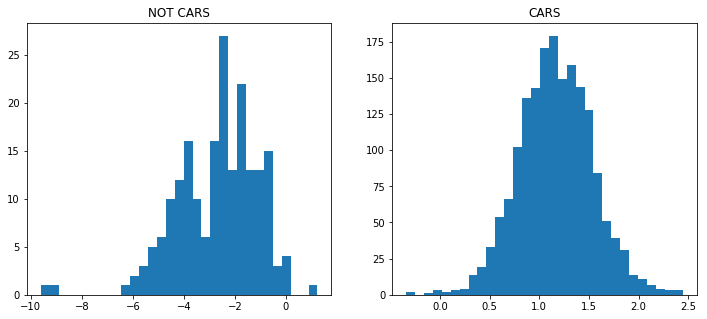

In [33]:
# Decision surface
dF  = svc.decision_function(X_test)
fig = plt.figure(figsize=(12,5))
plt.subplot(121)
pt = plt.hist(dF[y_test==0], bins=31) 
plt.title("NOT CARS")
plt.subplot(122)
pt = plt.hist(dF[y_test==1], bins=31) 
plt.title("CARS")

In [36]:
#Classifier
class Classifier():
    def __init__(self, clf, minDist=0):
        self.clf=clf
        self.minDist=minDist
        
    def predict(self, X):
        d=self.clf.decision_function(X)
        result=np.zeros(len(X))
        result[d>self.minDist]=1
        return result
    
    def score(self, X, y):
        p=self.predict(X)
        d=1-np.abs(p-y)
        return ((np.sum(d))/len(d))
    
clf = Classifier(svc, minDist=-0.5)
score = clf.score(X_test, y_test)
print('SVM score:', score)

SVM score: 0.995916283818


C:\Users\Karthik\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


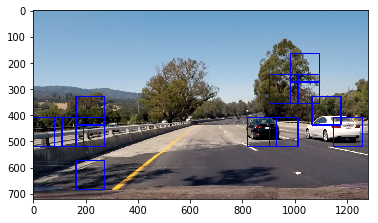

In [37]:
ptStartStop = [None, None] # Min and max to search in slide_window()
image     = mpimg.imread('.\\test_images\\test4.jpg')
imageCopy = np.copy(image)
image   = image.astype(np.float32)/255
windows = slide_window(image, x_start_stop=[None, None], y_start_stop = ptStartStop, 
                    xy_window=(110, 110), xy_overlap=(0.25, 0.25))

hotWindows = search_windows(image, windows, clf, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins,orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block,hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       
windowImage = draw_boxes(imageCopy, hotWindows, color=(0, 0, 255), thick=4)                    

plt.imshow(windowImage)



#You can see that there are false detections as well in above image. 

Next Step : Sliding Window Search Implementation
Describe how (and identify where in your code) you implemented a sliding window search. 
How did you decide what scales to search and how much to overlap windows?

Solution : - As in the lecture, it is good to search in the lower half part of the image where the possibility of car would 
           be too high and eliminate the sky and other parts. And also, since in the video input, total lower half also 
           could be split into kind of trapezium shape area for searching (to be specific, the other side of lane is not 
           our region of interest, but depends if you also want to detect vehicles on other side. But i do not find it useful)
           - Cars that are closer to the camera appear to be larger and far from camera appear to be smaller.
           - Looking for cars on the ride side of our camera is also good practice (oops! But not the best in all cases)
           - Assumption : The camera position is fixed. Else the 'MainWindow' which is the region of interest gets altered

#### Refining the pipeline: defining the global search window

Before starting the detection, I extracted the images from the video stream and can be found in VideoFrames folder.

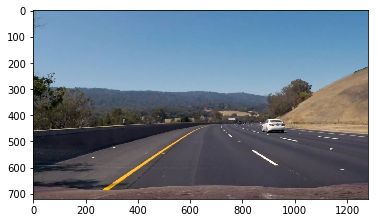

In [38]:
# Read the extracted frames form Video as starting point. Since it is a continuous stream, 
# reading a few frames
images=[mpimg.imread('.\\VideoFrames\\001.png'),
        mpimg.imread('.\\VideoFrames\\010.png'),
        mpimg.imread('.\\VideoFrames\\016.png'),
        mpimg.imread('.\\VideoFrames\\021.png'),
        mpimg.imread('.\\VideoFrames\\028.png'), 
        mpimg.imread('.\\VideoFrames\\031.png'),
        mpimg.imread('.\\VideoFrames\\036.png'),
        mpimg.imread('.\\VideoFrames\\041.png'), 
        mpimg.imread('.\\VideoFrames\\043.png')]
plt.imshow(images[4])

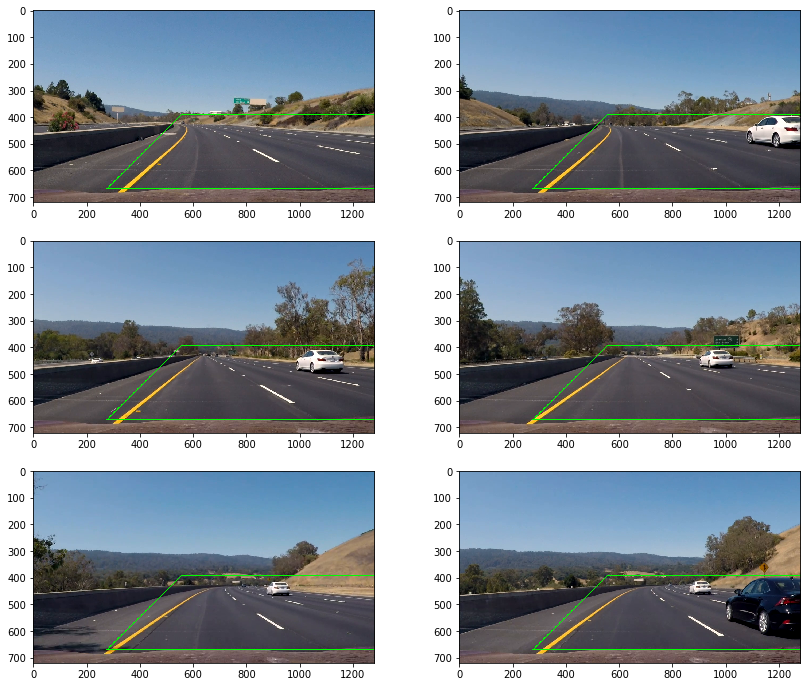

In [39]:
plt.figure(figsize=(14,12))
s=images[0].shape

h=s[0]; w=s[1]

globalWindow=[[556, 390], [w, 390], [w, h-50], [276, h-50]]
    
for i in range(6):
    plt.subplot(3, 2, i+1)
    rgb_poly=np.uint8(np.copy(images[i])*255)
    cv2.polylines(rgb_poly, np.array([globalWindow]), 1, (0,255,0), 2)
    plt.imshow(rgb_poly)


In [42]:
def region_of_interest(img, polygon):
    xMin=polygon[0][1]; xMax=xMin
    yMin=polygon[0][0]; yMax=yMin
    for i in range(1, len(polygon)):
        xMin=xMin if xMin<=polygon[i][0] else polygon[i][0]
        xMax=xMax if xMax>=polygon[i][0] else polygon[i][0]
        yMin=yMin if yMin<=polygon[i][1] else polygon[i][1]
        yMax=yMax if yMax>=polygon[i][1] else polygon[i][1]
    return img[yMin:yMax, xMin:xMax, :]

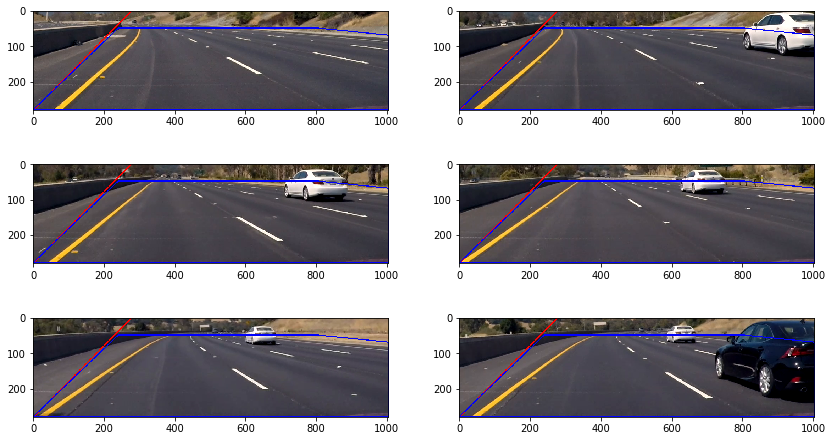

In [43]:

plt.figure(figsize=(14,8))
s=region_of_interest(images[0], globalWindow).shape
groundWindow=[[0,s[0]-1],[240,50],[800,50],[s[1]-1,70], [s[1]-1,s[0]-1]]
    
for i in range(6):
    plt.subplot(3, 2, i+1)
    rgb_poly=np.uint8(np.copy(images[i])*255)
    cv2.polylines(rgb_poly, np.array([globalWindow]), 1, (255,0,0), 2)
    roi=region_of_interest(rgb_poly, globalWindow)
    cv2.polylines(roi, np.array([groundWindow]), 1, (0,0,255), 2)
    plt.imshow(roi)

In [45]:
def perspective_scale(y):
    src=[[326, 60], [411, 60], [812, 280], [50, 280]]
    l0=src[2][0]-src[3][0]
    l1=src[1][0]-src[0][0]
    y0=src[2][1]
    y1=src[0][1]
    a = (l1-l0)/(y1-y0)
    b = 0.5*(l1+l0-a*(y1+y0))
    return (a*y+b)/l0

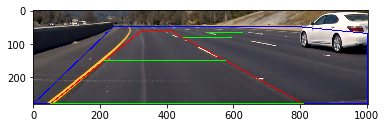

In [46]:
roi=region_of_interest(np.uint8(np.copy(images[1])*255), globalWindow)
src=[[326, 60], [411, 60], [812, 280], [50, 280]]
roi=cv2.polylines(roi, np.array([src]), 1, (255,0,0), 2)

cv2.polylines(roi, np.array([groundWindow]), 1, (0,0,255), 2)


l0=src[2][0]-src[3][0]
pt1=tuple(src[3]); pt2=(pt1[0]+l0, pt1[1])
cv2.line(roi, pt1, pt2, (0,255,0), thickness=4)
pt1=(213, 150); pt2=(pt1[0]+int(l0*perspective_scale(pt1[1])), pt1[1])
cv2.line(roi, pt1, pt2, (0,255,0), thickness=4)
pt1=(450, 80); pt2=(pt1[0]+int(l0*perspective_scale(pt1[1])), pt1[1])
cv2.line(roi, pt1, pt2, (0,255,0), thickness=2)
pt1=(520, 68); pt2=(pt1[0]+int(l0*perspective_scale(pt1[1])), pt1[1])
cv2.line(roi, pt1, pt2, (0,255,0), thickness=2)

plt.imshow(roi)

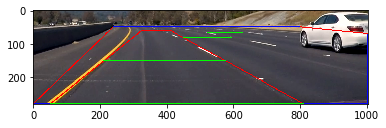

In [51]:
from libOwn import left_boundary, right_boundary, top_boundary, bottom_boundary

bb=bottom_boundary(); lbb=left_boundary(bb); rbb=(right_boundary(70))
tb=top_boundary(); ltb=left_boundary(tb); rtb=(right_boundary(tb))

cv2.line(roi, (lbb,bb), (ltb,tb), (255,0,0), thickness=2)
cv2.line(roi, (rbb,70), (rtb,tb), (255,0,0), thickness=2)
plt.imshow(roi)

#### Some Examples of Scaled Search Windows

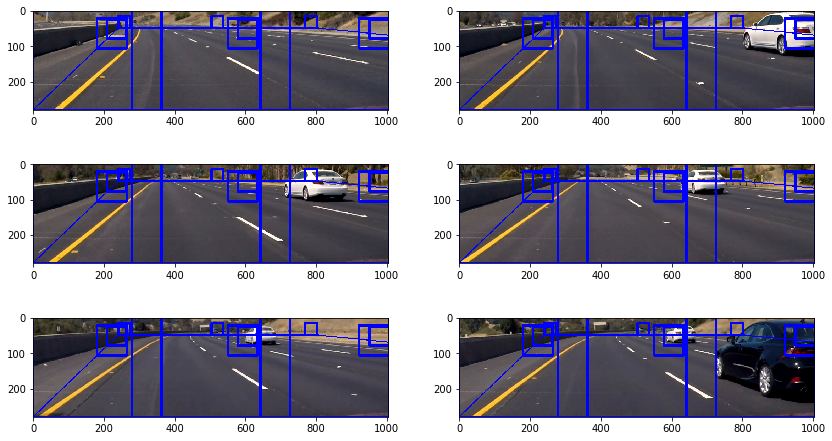

In [52]:
bl=int(0.37*l0)
ys=[tb,80, int(0.25*(bb-tb)+tb), bb]
ps=[0.0, 0.5, 1.0]

plt.figure(figsize=(14,8))

for i in range(6):
    roi=region_of_interest(np.uint8(np.copy(images[i])*255), globalWindow)
    cv2.polylines(roi, np.array([groundWindow]), 1, (0,0,255), 2)

    for y in ys:
        lb=left_boundary(y); rb=right_boundary(y)
        s=max(perspective_scale(y), 0.12)
        bl_s=int(bl*s)
        mDist=rb-lb-bl_s
        for p in ps:
            xl=lb+int(mDist*p); xr=xl+bl_s
            yb=y; yt=yb-bl_s
            cv2.rectangle(roi,(xl,yb),(xr,yt),(0,0,255),6) 
            #print((xl,yb),(xr,yt))

    plt.subplot(3, 2, i+1)
    plt.imshow(roi)

In [53]:
class Scan():
    def __init__(self, clf, X_scaler):
        self.clf=clf
        self.X_scaler=X_scaler
        self.color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
        self.orient = 9  # HOG orientations
        self.pix_per_cell = 8 # HOG pixels per cell
        self.cell_per_block = 2 # HOG cells per block
        self.cells_per_step_x = 2
        self.cells_per_step_y = 2
        self.hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
        self.spatial_size = (16, 16) # Spatial binning dimensions
        self.hist_bins = 32    # Number of histogram bins
        self.spatial_feat = True # Spatial features on or off
        self.hist_feat = False # Histogram features on or off
        self.hog_feat = True # HOG features on or off
        
        self.globalWindow=[[556, 390], [1280, 390], [1280, 720-50], [276, 720-50]]

        # perspective polygon
        src=[[326, 60], [411, 60], [812, 280], [50, 280]]
        l0=src[2][0]-src[3][0]
        self.bl=int(0.36*l0) # basic length
        self.scaleMin=bl/64 # scale factor for rescaling bl to 64 pixels

        # generate y values with approx. perspectively scaled spacing
        ys=range(50, bb, int((bb-50)/4))
        ss=[perspective_scale(y) for y in ys]
        ss=ss/np.sum(ss)
        sum_s=0
        y=50; ys=[y]
        for s in ss:
            y=y+s*(bb-50)
            ys.append(int(y))
        self.ys=ys
        
    # coordinate transformation of a list of points from roi to global coordinates
    def to_global(self, p_list):
        rect=rectangle(self.globalWindow)
        return [[p[0]+rect[0][0], p[1]+rect[0][1]] for p in p_list]
    
    # coordinate transformation of a list of points from global coordinates to roi
    def to_roi(self, p_list):
        rect=rectangle(self.globalWindow)
        return [[p[0]-rect[0][0], p[1]-rect[0][1]] for p in p_list]
    
    def fc(self, roi, lb, rb, ystart, ystop, s):
        return find_cars2(roi, lb, rb, ystart, ystop, s,
                          self.clf, self.X_scaler, self.orient, 
                          self.pix_per_cell, self.cell_per_block, 
                          self.cells_per_step_x, self.cells_per_step_y,
                          self.spatial_size, self.hist_bins)
        
    def scan_global(self, image):
        roi=region_of_interest(image, self.globalWindow)
        boxes=[]
        for y in self.ys:
            lb=left_boundary(y); rb=right_boundary(y)
            s=max(perspective_scale(y), 0.10)
            bl_s=int(self.bl*s)+1
            ystart = max(y-int(bl_s*1.5), 0)
            ystop = y+int(1*bl_s)+1
            
            b = self.fc(roi, lb, rb, ystart, ystop, s*self.scaleMin)
            boxes.extend(b)
            
        return [self.to_global(b) for b in boxes]
    
    def scan_local(self, image, bboxes):
        roi=region_of_interest(image, self.globalWindow)
        boxes=[]
        # first, scan horizon
        for y in self.ys[0:2]:
            lb=left_boundary(y); rb=right_boundary(y)
            s=max(perspective_scale(y), 0.10)
            bl_s=int(self.bl*s)+1
            ystart = max(y-int(bl_s*1.5), 0)
            ystop = y+int(1*bl_s)+1
            
            b = self.fc(roi, lb, rb, ystart, ystop, s*self.scaleMin)
            boxes.extend(b)
        # second, scan right half of the image
        for y in self.ys[2:]:
            lb=left_boundary(y); rb=right_boundary(y)
            lb=int(0.5*(lb+rb))
            s=max(perspective_scale(y), 0.10)
            bl_s=int(self.bl*s)+1
            ystart = max(y-int(bl_s*1.5), 0)
            ystop = y+int(1*bl_s)+1
            
            b = self.fc(roi, lb, rb, ystart, ystop, s*self.scaleMin)
            boxes.extend(b)
        # third, scan bounding boxes + surroundings
        for bbox in bboxes:
            topleft=np.array(bbox[0]); bottomright=np.array(bbox[1])
            size=(bottomright-topleft)*2 # rescaling the size of the box
            center=0.5*(bottomright+topleft)
            topleft=(center-0.5*size).astype(np.int); bottomright=(center+0.5*size).astype(np.int)
            corners=self.to_roi([topleft, bottomright]); 
            topleft=np.array(corners[0]); bottomright=np.array(corners[1])
            topleft[topleft<0]=0
            rect=rectangle(self.globalWindow); w=rect[1][0]-rect[0][0]; h=rect[1][1]-rect[0][1]
            bottomright[0]=bottomright[0] if bottomright[0]<w else w
            bottomright[1]=bottomright[1] if bottomright[1]<h else h            
            #print(w, h, topleft, bottomright)
            
            size=bottomright-topleft
            minlength=min(size[0], size[1])
            if minlength>5:
                scaleMin=minlength/64
                for s in [0.25, 0.5, 0.75, 1]:
                    b = self.fc(roi, topleft[0], bottomright[0], topleft[1], bottomright[1], s*scaleMin)
                    boxes.extend(b)
                
        return [self.to_global(b) for b in boxes]
        


C:\Users\Karthik\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


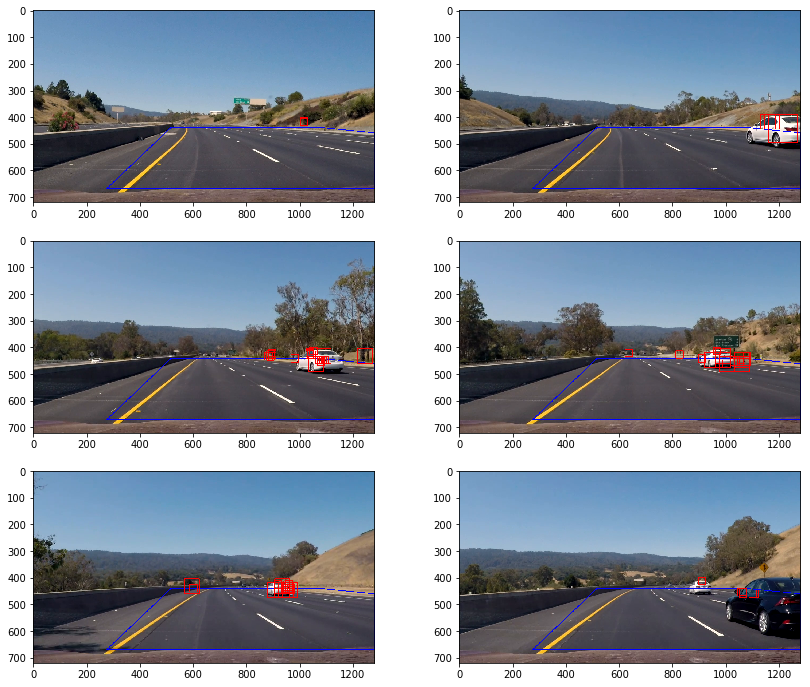

In [55]:
from libOwn import *

clf=Classifier(svc, minDist=0.5) #minimum distance = 0.5
scanner=Scan(clf, X_scaler)

plt.figure(figsize=(14,12))

boxes_frames=[]
for i in range(6):
    draw_image=np.uint8(np.copy(images[i])*255)
    cv2.polylines(draw_image, np.array([scanner.to_global(groundWindow)]), 1, (0,0,255), 2)
    boxes=scanner.scan_global(images[i])
    draw_image=draw_boxes(draw_image, boxes, color=(255, 0, 0), thick=2)
    boxes_frames.append(boxes)    
    plt.subplot(3, 2, i+1)
    plt.imshow(draw_image)
    

####Multiple Detections and False Positives###


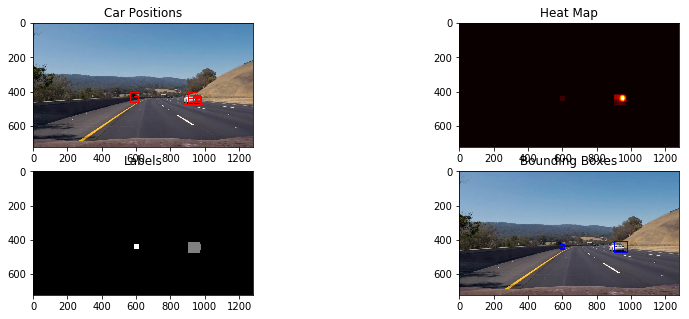

In [56]:
import pickle
from scipy.ndimage.measurements import label
from libOwn import *

i=4
boxes=boxes_frames[i]
image=images[i]

plt.figure(figsize=(14,5))
draw_img=(image*255).astype(np.uint8)
draw_img = draw_boxes(draw_img, boxes, color=(255, 0, 0), thick=2)
plt.subplot(221)
plt.imshow(draw_img)
plt.title('Car Positions')

heat = np.zeros_like(draw_img[:,:,0]).astype(np.float)
heat = add_heat(heat,boxes) # Add heat to each box in box list
heat = apply_threshold(heat,1) # Apply threshold to help remove false positives
heatmap = np.clip(heat, 0, 255) # Visualize the heatmap when displaying
labels = label(heatmap) # Find final boxes from heatmap using label function
draw_img = draw_labeled_bboxes((image*255).astype(np.uint8), labels)

plt.subplot(222)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
plt.subplot(223)
plt.imshow(labels[0], cmap='gray')
plt.title('Labels')
plt.subplot(224)
plt.imshow(draw_img)
plt.title('Bounding Boxes')



####Video Implementation Pipeline###
Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)
Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

In [57]:
from moviepy.editor import VideoFileClip
from CameraCalib import *
from libUdacity import *
from libOwn import *

class ProcessImage():
    def __init__(self, scanner, text_file):
        self.text_file=text_file
        self.scanner=scanner
        self.heat = None
        self.bboxes = None
        self.counter = 0

    def pipelineTracking(self, image):
        img = image.astype(np.float32)/255
        draw_image=np.copy(image)
        
        if self.counter==0:
            boxes=self.scanner.scan_global(img)
        else:
            boxes=self.scanner.scan_local(img, self.bboxes)

        p=0.85
        if self.heat!=None:
            self.heat=self.heat*p
        else:
            self.heat = np.zeros_like(image[:,:,0]).astype(np.float)

        self.heat = add_heat(self.heat,boxes)         # Add heat to each box in box list
        heat = apply_threshold(self.heat,1*0.5/(1-p)) # Apply threshold to help remove false positives
        heatmap = np.clip(self.heat, 0, 255)         # Visualize the heatmap when displaying    
        labels = label(heatmap)        # Find final boxes from heatmap using label function
        
        self.bboxes = get_labeled_bboxes(labels)
        result = draw_labeled_bboxes2(np.copy(image), self.bboxes)

        h=self.heat*10
        statimg=np.zeros_like(draw_img); 
        statimg[:,:,0]=np.clip(h, 0, 255).astype(np.uint8)
        statimg[:,:,1]=(np.clip(h, 256, 511)-256).astype(np.uint8)
        statimg[:,:,2]=(np.clip(h, 512, 512+255)-512).astype(np.uint8)
        statimg=cv2.resize(statimg, None, fx=1/4, fy=1/4)
        y_offset=50; x_offset=result.shape[1]-statimg.shape[1]-80
        result[y_offset:y_offset+statimg.shape[0], x_offset:x_offset+statimg.shape[1]] = statimg
        self.counter=1        
        return result

    def __call__(self, image):
        result=self.pipelineTracking(image)
        return result



In [58]:
video_output = 'project_video_out.mp4'
clip1 = VideoFileClip("project_video.mp4")

clf=Classifier(svc, minDist=0.75)
scanner=Scan(clf, X_scaler)

text_file = open("Output.txt", "w")
process_image=ProcessImage(scanner, text_file)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(video_output, audio=False)
text_file.close()

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████████████████████████████████▉| 1260/1261 [47:16<00:05,  5.08s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Wall time: 47min 17s


####Discussion####
Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?

- The speed of the car also plays an important role here. If the cars are travelling very high speed, the slow filter that has been used here to smoothen the bound boxes and to suppress false positives. We know that if there was already a bound box, then the probability to find a car is high (position is looked in scan_local in class Scan())
- Different weights could be given to detect in the regions where there is probability to find a car and less weightage to the regions where there is less probability to find a car.
- Different distance to decision surface could improve the problems
- If processing of images is done faster (using a high GPU), then the pipeline will run very faster and will be able to detect cars quickly including cars which are overtaking at very fast speed.
- Although the pipeline is running bit slow in my PC, you can see the time taken to run the whole ProcessImage pipeline. This could be the reason for small boxes appearing there (I am not sure), but if the pipeline is run on very high processing GPU, things would definitely improve I guess.